<a href="https://colab.research.google.com/github/gabrieldasneves/MachineLearnStudies/blob/main/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image Classification

My goal with this notebook is to practice the knowledge gained about [neural networks](https://www.deeplearningbook.com.br/o-que-sao-redes-neurais-artificiais-profundas/). For this, I will use the  [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which is a dataset composed of 60k color images with a dimension of 32×32 pixels. A neural network will be developed and evaluated to classify the images.


##Useful imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K

print(tf.__version__)

2.5.0


## Download and dataset separation



Here we are going to take a look at our data and separate it into two groups: training and testing

In [2]:
(X_train, y_train), (X_test, y_test)  = cifar10.load_data() # separation

In [3]:
print(X_train.shape)
print(X_train.dtype)

(50000, 32, 32, 3)
uint8


Obs: in color images we have 3 matrices of the same height and width, varying only the channel for one of the basic colors.

In [4]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255 # Normalization. Here we leave the pixels between 0 and 1
X_test /= 255

Looking at our dataset

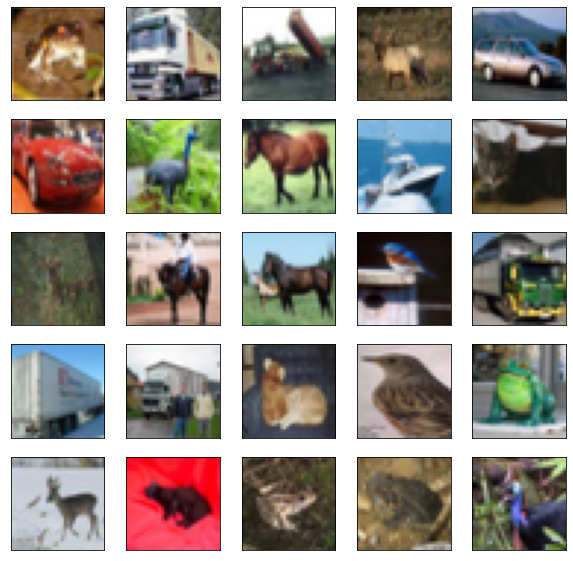

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap=plt.cm.binary)

plt.show()

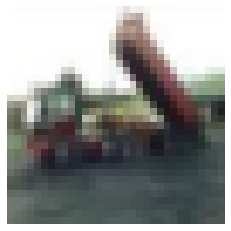

In [6]:
plt.imshow(X_train[2])
plt.axis('off')
plt.show()

##The Neural Network

Now let's create our neural network model. For the inner layers I chose a series of convolution layers, where we will reduce the dimensions, and max pooling, where we will highlight the dominant information and reduce the noise of the images.

The deeper the convolution layers, the more detail we preserve.

In [7]:
num_classes = 10
    
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax')) # returns matrix of 10 possibilities

Below, we can see a summary of our model

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          8

In [9]:
hidden1 = model.layers[2]
hidden1.name

'conv2d_1'

In [17]:
weights, biases = hidden1.get_weights()
weights #looking at the weights

array([[[[-4.12478782e-02,  2.26059064e-01, -5.29110804e-03, ...,
           1.20302988e-02, -4.52466495e-03,  4.56279404e-02],
         [ 4.06572111e-02,  2.47925773e-01,  2.63840798e-02, ...,
           3.22558098e-02,  4.30258699e-02,  3.90421413e-02],
         [-2.67547462e-02, -7.32286694e-03,  3.25784571e-02, ...,
           1.07723027e-02,  4.72624674e-02, -7.47810025e-03],
         ...,
         [-6.09210040e-03, -3.14936787e-02, -1.51255056e-02, ...,
          -3.54062300e-03,  4.26357873e-02, -2.65453476e-02],
         [-3.17469537e-02, -1.75371692e-01, -4.41765860e-02, ...,
          -2.79479045e-02,  3.70011851e-02,  5.05163558e-02],
         [-4.40684073e-02,  2.40635946e-01, -3.84226888e-02, ...,
           2.40846500e-02, -4.48583588e-02, -1.26898913e-02]],

        [[ 9.39202029e-03,  2.04082251e-01, -1.14598740e-02, ...,
           3.48638408e-02,  9.25782975e-03,  2.49681752e-02],
         [-1.34937931e-02,  1.81533322e-01, -5.18788435e-02, ...,
          -5.36788404e

I've tried some optimizers and "loss" but those were the ones that brought me the best accuracy.

"Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments." 
( [Source](https://keras.io/api/optimizers/adam/))

In [11]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
1563/1563 [==============================] - 64s 13ms/step - loss: 0.0789 - accuracy: 0.3138 - val_loss: 0.0619 - val_accuracy: 0.5217
Epoch 2/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0594 - accuracy: 0.5379 - val_loss: 0.0542 - val_accuracy: 0.5864
Epoch 3/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0525 - accuracy: 0.5986 - val_loss: 0.0503 - val_accuracy: 0.6183
Epoch 4/10
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0474 - accuracy: 0.6423 - val_loss: 0.0475 - val_accuracy: 0.6464
Epoch 5/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0441 - accuracy: 0.6711 - val_loss: 0.0464 - val_accuracy: 0.6526
Epoch 6/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0412 - accuracy: 0.6959 - val_loss: 0.0460 - val_accuracy: 0.6600
Epoch 7/10
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0396 - accuracy: 0.7074 - val_loss: 0.0437 -

Let's see how our parameters to be evaluated evolved with epochs...

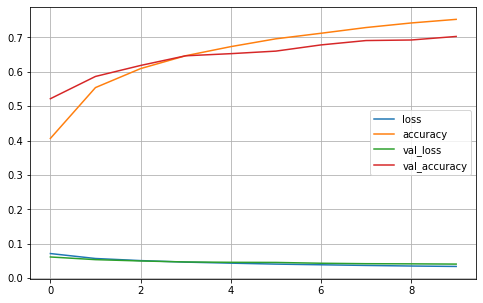

In [13]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [14]:
X_new = X_test[:3]
y_proba = model.predict(X_new)

In [15]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([3, 8, 8])

Finally, here's the accuracy:

In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.26%


We didn't get very high accuracy but the loss was small